<a href="https://colab.research.google.com/github/fahmida0404/network-threat-detection/blob/main/notebooks/UNSW_NB15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing Libraries**

In [1]:
import zipfile
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import  make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

### **Data Collection**

In [2]:
path = "/content/drive/MyDrive/IDS/Dataset/UNSW-NB15.zip" #zip file path
dataset = "/content/UNSW-NB15" #dataset path

# unzip and extract files
if not os.path.exists(dataset):
  !mkdir -p {dataset}
  !unzip -j {path} -d {dataset}

Archive:  /content/drive/MyDrive/IDS/Dataset/UNSW-NB15.zip
 extracting: /content/UNSW-NB15/UNSW_NB15_testing-set.csv  
 extracting: /content/UNSW-NB15/UNSW_NB15_training-set.csv  


In [3]:
col_names = ['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label']

In [4]:
data = pd.read_csv("/content/UNSW-NB15/UNSW_NB15_testing-set.csv",header=None,skiprows=1,index_col=0,names=col_names)

In [5]:
data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
4,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [6]:
data.shape

(82332, 44)

In [7]:
data.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [8]:
data.isnull().sum()

,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0
sttl,0


In [9]:
data= data.drop_duplicates(keep='first')
print("Duplicates:", data.duplicated().sum())

Duplicates: 0


In [10]:
data.shape

(55945, 44)

In [11]:
# Check columns with constant values (only 1 unique value)
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print("Columns with constant values:", constant_columns)
data = data.drop(constant_columns, axis=1)

Columns with constant values: []


In [12]:
for col_name in data.columns:
    if data[col_name].dtypes == 'object' :
        unique_cat = len(data[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'proto' has 131 categories
Feature 'service' has 13 categories
Feature 'state' has 7 categories
Feature 'attack_cat' has 10 categories


In [13]:
data["attack_cat"].value_counts()

,count
attack_cat,
Normal,34206
Exploits,7609
Fuzzers,4838
Generic,3657
Reconnaissance,2703
DoS,1718
Analysis,446
Shellcode,378
Backdoor,346


In [14]:
data=data.drop(['attack_cat'],axis=1)

In [15]:
data["label"].unique()

array([0, 1])

In [16]:
data.label.value_counts()

,count
label,
0,34206
1,21739


In [17]:
cols = ['proto','service','state']

for i in cols:
    en = LabelEncoder()

    data[i] = en.fit_transform(data[i])

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55945 entries, 1 to 82329
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                55945 non-null  float64
 1   proto              55945 non-null  int64  
 2   service            55945 non-null  int64  
 3   state              55945 non-null  int64  
 4   spkts              55945 non-null  int64  
 5   dpkts              55945 non-null  int64  
 6   sbytes             55945 non-null  int64  
 7   dbytes             55945 non-null  int64  
 8   rate               55945 non-null  float64
 9   sttl               55945 non-null  int64  
 10  dttl               55945 non-null  int64  
 11  sload              55945 non-null  float64
 12  dload              55945 non-null  float64
 13  sloss              55945 non-null  int64  
 14  dloss              55945 non-null  int64  
 15  sinpkt             55945 non-null  float64
 16  dinpkt             55945 no

In [19]:
X = data.drop('label', axis=1)
y = data['label']

**Train-Test Split**

In [20]:
X_trainval, X_test, y_trainval, y_test  = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
X_trainval.shape

(44756, 42)

In [22]:
X_test.shape

(11189, 42)

In [23]:
y_trainval.value_counts()

,count
label,
0,27365
1,17391


In [24]:
y_test.value_counts()

,count
label,
0,6841
1,4348


**Feature Scaling**

In [25]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the feature data and transform it
X_trainval = pd.DataFrame(scaler.fit_transform(X_trainval), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [26]:
X_trainval.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,8.199452e-03,0.853846,0.000000,0.6,0.000686,0.000729,0.000025,0.000024,0.000030,0.996078,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.081967,0.0
1,1.703334e-05,0.900000,0.166667,0.4,0.000098,0.000182,0.000009,0.000012,0.002935,0.121569,...,0.039216,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,2.412592e-02,0.853846,0.000000,0.6,0.005785,0.001276,0.004972,0.000042,0.000050,0.996078,...,0.000000,0.000000,0.0,0.032258,0.0,0.0,0.0,0.019608,0.032787,0.0
3,1.205164e-02,0.853846,0.000000,0.6,0.000882,0.000729,0.000076,0.000024,0.000024,0.996078,...,0.019608,0.000000,0.0,0.016129,0.0,0.0,0.0,0.019608,0.000000,0.0
4,6.666668e-08,0.900000,0.000000,0.8,0.000098,0.000000,0.000115,0.000000,0.250000,0.996078,...,0.176471,0.176471,0.0,0.145161,0.0,0.0,0.0,0.176471,0.459016,0.0


In [27]:
X_test.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,2.355067e-03,0.853846,0.00,0.4,0.000490,0.000182,0.000071,0.000006,0.000050,0.243137,...,0.058824,0.058824,0.0,0.096774,0.0,0.0,0.0,0.058824,0.098361,0.0
1,1.500000e-07,0.900000,0.00,0.8,0.000098,0.000000,0.000004,0.000000,0.111111,0.996078,...,0.000000,0.000000,0.0,0.048387,0.0,0.0,0.0,0.000000,0.049180,0.0
2,1.659350e-03,0.853846,0.00,0.6,0.011864,0.011486,0.000569,0.001036,0.002481,0.121569,...,0.078431,0.000000,0.0,0.000000,0.0,0.0,0.0,0.019608,0.049180,0.0
3,6.381910e-02,0.853846,0.25,0.6,0.002255,0.002005,0.000093,0.000113,0.000012,0.243137,...,0.019608,0.000000,0.0,0.016129,0.5,0.5,0.0,0.019608,0.000000,0.0
4,1.139559e-02,0.853846,0.00,0.6,0.000882,0.000729,0.000035,0.000024,0.000025,0.996078,...,0.000000,0.000000,0.0,0.016129,0.0,0.0,0.0,0.039216,0.016393,0.0


### **Feature Selection**

In [28]:
ig = mutual_info_classif(X_trainval, y_trainval)

In [29]:
# Create a dictionary of feature importance scores
feature_scores = {}
for i in range(len(X.columns)):
    feature_scores[X.columns[i]] = ig[i]

# Sort the features by importance score in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Print all feature importance scores
print("Feature Importance Scores:")
for feature, score in sorted_features:
    print(f"{feature}: {score:.3f}")

Feature Importance Scores:
sbytes: 0.362
dbytes: 0.258
smean: 0.252
ct_state_ttl: 0.225
dmean: 0.200
dttl: 0.194
sload: 0.193
sttl: 0.192
synack: 0.186
tcprtt: 0.186
dinpkt: 0.178
rate: 0.175
dur: 0.160
ackdat: 0.156
dpkts: 0.148
dload: 0.138
sinpkt: 0.121
djit: 0.104
sjit: 0.102
state: 0.094
ct_srv_dst: 0.092
spkts: 0.090
ct_srv_src: 0.070
dloss: 0.069
ct_dst_sport_ltm: 0.068
proto: 0.053
sloss: 0.049
ct_dst_src_ltm: 0.048
response_body_len: 0.044
ct_dst_ltm: 0.039
ct_src_ltm: 0.030
ct_src_dport_ltm: 0.029
service: 0.028
stcpb: 0.015
swin: 0.012
dtcpb: 0.010
dwin: 0.007
ct_flw_http_mthd: 0.006
is_ftp_login: 0.001
ct_ftp_cmd: 0.001
trans_depth: 0.000
is_sm_ips_ports: 0.000


In [30]:
threshold = 0.05
selected_features = [column for column in feature_scores.keys() if feature_scores[column]>=threshold]
# Select features only in dataframe
X_trainval = X_trainval[selected_features]
X_test = X_test[selected_features]

In [31]:
X_trainval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44756 entries, 0 to 44755
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dur               44756 non-null  float64
 1   proto             44756 non-null  float64
 2   state             44756 non-null  float64
 3   spkts             44756 non-null  float64
 4   dpkts             44756 non-null  float64
 5   sbytes            44756 non-null  float64
 6   dbytes            44756 non-null  float64
 7   rate              44756 non-null  float64
 8   sttl              44756 non-null  float64
 9   dttl              44756 non-null  float64
 10  sload             44756 non-null  float64
 11  dload             44756 non-null  float64
 12  dloss             44756 non-null  float64
 13  sinpkt            44756 non-null  float64
 14  dinpkt            44756 non-null  float64
 15  sjit              44756 non-null  float64
 16  djit              44756 non-null  float6

In [32]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11189 entries, 0 to 11188
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dur               11189 non-null  float64
 1   proto             11189 non-null  float64
 2   state             11189 non-null  float64
 3   spkts             11189 non-null  float64
 4   dpkts             11189 non-null  float64
 5   sbytes            11189 non-null  float64
 6   dbytes            11189 non-null  float64
 7   rate              11189 non-null  float64
 8   sttl              11189 non-null  float64
 9   dttl              11189 non-null  float64
 10  sload             11189 non-null  float64
 11  dload             11189 non-null  float64
 12  dloss             11189 non-null  float64
 13  sinpkt            11189 non-null  float64
 14  dinpkt            11189 non-null  float64
 15  sjit              11189 non-null  float64
 16  djit              11189 non-null  float6

### **Evaluation metrics**

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #5 fold cv

In [34]:
def tnr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def fpr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

def fnr_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

In [35]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'tpr': make_scorer(recall_score),  # TPR = recall for class 1
    'tnr': make_scorer(tnr_score), # TNR for class 0
    'fpr': make_scorer(fpr_score),
    'fnr': make_scorer(fnr_score),
    'f1_score': make_scorer(f1_score),  # F1-score for class 1
}

### **XGBoost**

In [36]:
XGB = XGBClassifier(n_estimators=40, max_depth=20, eta=0.7, alpha=1, random_state=42, n_jobs=-1)

In [37]:
start_time = time.time()
results = cross_validate(XGB, X_trainval, y_trainval, cv=skf, scoring=scoring, n_jobs=-1) #Obtain evaluation metrics

# Display average scores across all folds
print("\nAverage Accuracy:", results['test_accuracy'].mean())
print("Average Sensitivity (TPR):", results['test_tpr'].mean())
print("Average Specificity (TNR):", results['test_tnr'].mean())
print("Average FPR:", results['test_fpr'].mean())
print("Average FNR: ", results['test_fnr'].mean())
print("Average F1-score:", results['test_f1_score'].mean())

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution Time:", execution_time, "seconds")
print("\nExecution Time:", execution_time/60, "minutes")


Average Accuracy: 0.9243007031930072
Average Sensitivity (TPR): 0.880686055047115
Average Specificity (TNR): 0.9520190023752969
Average FPR: 0.04798099762470309
Average FNR:  0.11931394495288497
Average F1-score: 0.9004003508072298

Execution Time: 6.007959365844727 seconds

Execution Time: 0.1001326560974121 minutes


In [40]:
start_time = time.time()

XGB.fit(X_trainval, y_trainval)
y_pred = XGB.predict(X_test)
y_pred_proba = XGB.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
tpr = recall_score(y_test, y_pred)
tnr = tnr_score(y_test, y_pred)
fpr = fpr_score(y_test, y_pred)
fnr = fnr_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Sensitivity (TPR):", tpr)
print("Specificity (TNR):", tnr)
print("FPR:", fpr)
print("FNR:", fnr)
print("F1-score:", f1)

end_time = time.time()
execution_time = end_time - start_time
print("\nExecution Time:", execution_time, "seconds")
print("\nExecution Time:", execution_time/60, "minutes")

Accuracy: 0.9294843149521852
Sensitivity (TPR): 0.8847746090156394
Specificity (TNR): 0.9579008916825026
FPR: 0.04209910831749744
FNR: 0.11522539098436063
F1-score: 0.9069904514912177

Execution Time: 2.8498330116271973 seconds

Execution Time: 0.04749721686045329 minutes


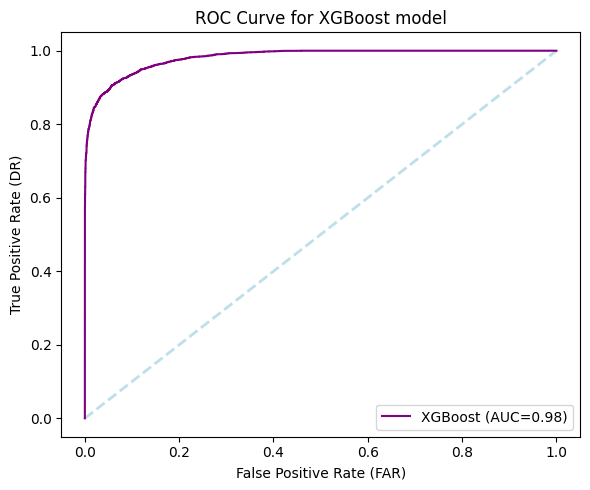

In [42]:
plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightblue', alpha=0.8)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc_score:.2f})", color="purple")

plt.title("ROC Curve for XGBoost model")
plt.xlabel('False Positive Rate (FAR)')
plt.ylabel('True Positive Rate (DR)')
plt.legend()

plt.tight_layout()
plt.show()